In [1]:
import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt


sys.path.append('../')

from architectures import*
from deepprior import*
from utils import*

# Data

In [2]:
i = 0
T = 32

Truth = np.load('../data/ground_truth/ground_truth.npy')[:,-1-128:-1,0:128]
Obs = np.load('../data/observations/ssh_tracks.npy')[:,-1-128:-1,0:128]
Mask = (-1*np.load('../data/observations/mask.npy')+1)[:,-1-128:-1,0:128]
Oi = np.load('../data/estimate/OI/oi_1year.npy')[:,-1-128:-1,0:128]
                           
truth = torch.Tensor(Truth[i:i+T,:,:])
obs = torch.Tensor(Obs[i:i+T,:,:])
mask = torch.Tensor(Mask[i:i+T,:,:])
oi = torch.Tensor(Oi[i:i+T,:,:])

------- t= 0 -------


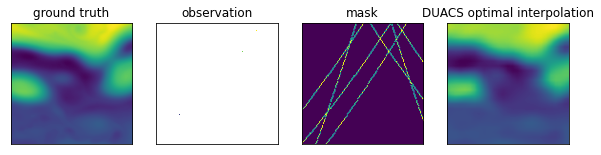

------- t= 16 -------


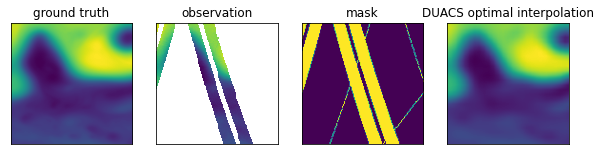

In [3]:
sub = 16

for t in range(T):
    
    if t % sub == 0:
        print('------- t=',t,'-------')
        plt.figure(figsize=(10,10))
        
        plt.subplot(1,4,1)
        plt.imshow(truth[i+t,:,:])
        plt.title('ground truth')
        plt.yticks([])
        plt.xticks([])

        plt.subplot(1,4,2)
        plt.imshow(obs[i+t,:,:])
        plt.title('observation')
        plt.yticks([])
        plt.xticks([])

        plt.subplot(1,4,3)
        plt.imshow(mask[i+t,:,:])
        plt.title('mask')
        plt.yticks([])
        plt.xticks([])

        plt.subplot(1,4,4)
        plt.imshow(oi[i+t,:,:])
        plt.title('DUACS optimal interpolation')
        plt.yticks([])
        plt.xticks([])

        plt.show()

In [4]:
# removing nan
obs[obs!=obs]=42

# Deep prior

In [5]:
# input dim
n_z  = 100

# input
z = torch.randn(n_z, 1, 1,1)

# neural network
net = ST_DCGNet(n_z=n_z, n_channel=T)

In [6]:
net.forward(z).shape

torch.Size([32, 128, 128])

# Optimization loop

In [7]:
# energy function

def J(X, Obs, Mask): 
        
        j = ((Obs - X)*Mask*(Obs - X)).mean()  
        
        return j
    

# optimizer

lr=0.01
beta1=0.9
n_epoch=2000

optimizer = optim.Adam(net.parameters(),lr=lr, betas=(beta1, 0.999))

# store

losses=[]
rmses_truth=[]

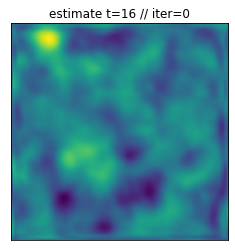

In [ ]:
# loop

for i in range(n_epoch):
    
    net.zero_grad()
    loss=0

    X=net.forward(z)
    
    if i % 50 == 0:
        
        plt.imshow(X[int(T/2),:,:].detach())
        plt.title('estimate t='+str(int(T/2))+' // iter='+str(i))
        plt.yticks([])
        plt.xticks([])
        plt.show()

    loss = J(X, obs, mask)
    losses.append(loss.item())
    
    rmse_truth = J(X,truth, torch.ones(X.shape))
    rmses_truth.append(rmse_truth)

    loss.backward(retain_graph=True)
    optimizer.step()

# Results

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(np.array(losses))
plt.title('J')
plt.yscale("log")
plt.grid()

plt.subplot(1,3,2)
plt.plot((np.array(cheat_rmse)))
plt.title('RMSE')
#plt.yscale("log")
plt.grid()

plt.subplot(1,3,3)
plt.plot(np.array(cheat_ssim))
plt.title('SSIM')
#plt.yscale("log")
plt.grid()

# Class

In [ ]:
class DeepPrior():
    
    def __init__(self, net,
                 lr=0.01, beta1=0.9, n_epoch=2000):
    
        self.net=net
        
        self.n_epoch=n_epoch
        self.lr=lr
        self.beta1=beta1
        
        self.optimizer = optim.Adam(self.net.parameters(),
                                    lr=self.lr, betas=(self.beta1, 0.999))

        self.X=0
        self.losses=[]

    
    def J(self, X, Obs, Mask): 
        
        j = ((Obs - X)*Mask*(Obs - X)).mean()  
        
        return j
    

    def fit(self, inpt, Obs, Mask, device='cpu'):
        
        device=torch.device(device)
        
        self.net.to(device)
        inpt = inpt.to(device)
        Obs = Obs.to(device)
        Mask = Mask.to(device)
        
        for i in range(self.n_epoch):
            
            self.net.zero_grad()
            loss=0
        
            X=self.net.forward(inpt).squeeze(0)
            self.X=X
            
            loss = self.J(X, Obs, Mask)
                
            self.losses.append(loss.item())
            
            loss.backward(retain_graph=True)
            self.optimizer.step()